In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from joblib import dump, load
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kabupaten.csv to kabupaten (1).csv
Saving makanan_khas.csv to makanan_khas (1).csv
Saving provinsi.csv to provinsi (1).csv
Saving restaurant.csv to restaurant (2).csv
Saving reting.csv to reting (1).csv


In [ ]:
restaurant = pd.read_csv('restaurant.csv')
provinsi = pd.read_csv('provinsi.csv')
makanan_khas = pd.read_csv('makanan_khas.csv')
rating = pd.read_csv('reting.csv')

In [ ]:
restaurant_provinsi = pd.merge(restaurant, provinsi, on='id_provinsi')
restaurant_provinsi_makanan_khas = pd.merge(restaurant_provinsi, makanan_khas, on='id_makanan')
data_gabungan = pd.merge(restaurant_provinsi_makanan_khas, rating, on='id_reting')
data_gabungan = data_gabungan[['id_restaurant','id_reting', 'nama_tempat', 'alamat', 'id_provinsi', 'nama_provinsi', 'id_makanan', 'harga', 'deskripsi', 'long', 'lat']]


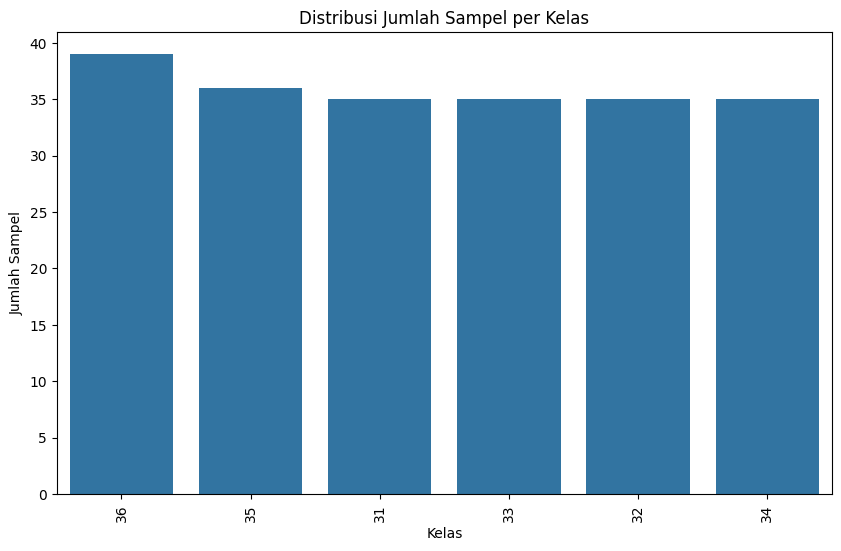

In [ ]:
class_column = 'id_provinsi'
plt.figure(figsize=(10, 6))
sns.countplot(data=data_gabungan, x=class_column, order=data_gabungan[class_column].value_counts().index)
plt.title('Distribusi Jumlah Sampel per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=90)
plt.show()

In [ ]:
samples_per_class = data_gabungan[class_column].value_counts()
print(f"Jumlah sampel per kelas:\n{samples_per_class}")

Jumlah sampel per kelas:
id_provinsi
36    39
35    36
31    35
33    35
32    35
34    35
Name: count, dtype: int64


In [ ]:
samples_per_class = data_gabungan[class_column].value_counts()
print(f"Statistik Jumlah Sampel per Kelas:\n{samples_per_class.describe()}")
print(f"Jumlah sampel minimal dalam satu kelas: {samples_per_class.min()}")
print(f"Jumlah sampel maksimal dalam satu kelas: {samples_per_class.max()}")

Statistik Jumlah Sampel per Kelas:
count     6.000000
mean     35.833333
std       1.602082
min      35.000000
25%      35.000000
50%      35.000000
75%      35.750000
max      39.000000
Name: count, dtype: float64
Jumlah sampel minimal dalam satu kelas: 35
Jumlah sampel maksimal dalam satu kelas: 39


In [ ]:
data_gabungan.isnull().sum().sort_values(ascending = False)

id_restaurant    0
id_reting        0
nama_tempat      0
alamat           0
id_provinsi      0
nama_provinsi    0
id_makanan       0
harga            0
deskripsi        0
long             0
lat              0
dtype: int64

In [ ]:
data_gabungan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_restaurant  215 non-null    int64  
 1   id_reting      215 non-null    int64  
 2   nama_tempat    215 non-null    object 
 3   alamat         215 non-null    object 
 4   id_provinsi    215 non-null    int64  
 5   nama_provinsi  215 non-null    object 
 6   id_makanan     215 non-null    int64  
 7   harga          215 non-null    object 
 8   deskripsi      215 non-null    object 
 9   long           215 non-null    float64
 10  lat            215 non-null    float64
dtypes: float64(2), int64(4), object(5)
memory usage: 18.6+ KB


In [ ]:
data_gabungan.duplicated().sum()

0

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

user_lat = -6.200000
user_lon = 106.816666

data_gabungan['distance'] = data_gabungan.apply(lambda row: haversine(user_lat, user_lon, row['lat'], row['long']), axis=1)

# Filter restoran yang berjarak maksimal 20 km
filtered_restaurants = data_gabungan[data_gabungan['distance'] <= 20]

In [ ]:
# Standardisasi fitur
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_restaurants[['lat', 'long']])

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_restaurants['cluster'] = kmeans.fit_predict(scaled_features)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, filtered_restaurants['cluster'], test_size=0.2, random_state=42)

# Mengonversi label ke bentuk categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# Membangun model TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train_cat, epochs=150, validation_split=0.2, verbose=2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-22-f057e6904fdc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_restaurants['cluster'] = kmeans.fit_predict(scaled_features)


Epoch 1/150
1/1 - 2s - loss: 1.6170 - accuracy: 0.1364 - val_loss: 1.6329 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/150
1/1 - 0s - loss: 1.5804 - accuracy: 0.2273 - val_loss: 1.6208 - val_accuracy: 0.0000e+00 - 54ms/epoch - 54ms/step
Epoch 3/150
1/1 - 0s - loss: 1.5462 - accuracy: 0.4091 - val_loss: 1.6111 - val_accuracy: 0.0000e+00 - 54ms/epoch - 54ms/step
Epoch 4/150
1/1 - 0s - loss: 1.5140 - accuracy: 0.5455 - val_loss: 1.6017 - val_accuracy: 0.1667 - 37ms/epoch - 37ms/step
Epoch 5/150
1/1 - 0s - loss: 1.4836 - accuracy: 0.6818 - val_loss: 1.5928 - val_accuracy: 0.1667 - 54ms/epoch - 54ms/step
Epoch 6/150
1/1 - 0s - loss: 1.4547 - accuracy: 0.6818 - val_loss: 1.5837 - val_accuracy: 0.1667 - 52ms/epoch - 52ms/step
Epoch 7/150
1/1 - 0s - loss: 1.4272 - accuracy: 0.6818 - val_loss: 1.5749 - val_accuracy: 0.1667 - 35ms/epoch - 35ms/step
Epoch 8/150
1/1 - 0s - loss: 1.4004 - accuracy: 0.7273 - val_loss: 1.5666 - val_accuracy: 0.1667 - 37ms/epoch - 37ms/step
Epoch 9/150
1/1 

In [ ]:
# Evaluasi model pada set pelatihan
train_loss, train_accuracy = model.evaluate(X_train, y_train_cat, verbose=2)
print(f'Akurasi set pelatihan: {train_accuracy:.2f}%, Loss set pelatihan: {train_loss:.2f}')

1/1 - 0s - loss: 0.1077 - accuracy: 1.0000 - 20ms/epoch - 20ms/step
Akurasi set pelatihan: 1.00%, Loss set pelatihan: 0.11


In [ ]:
# Evaluasi model pada set pengujian
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=2)
print('Akurasi model pada set pengujian: {:5.2f}%, Loss set pengujian: {:.2f}'.format(100 * test_accuracy, test_loss))

1/1 - 0s - loss: 0.3836 - accuracy: 0.7143 - 42ms/epoch - 42ms/step
Akurasi model pada set pengujian: 71.43%, Loss set pengujian: 0.38


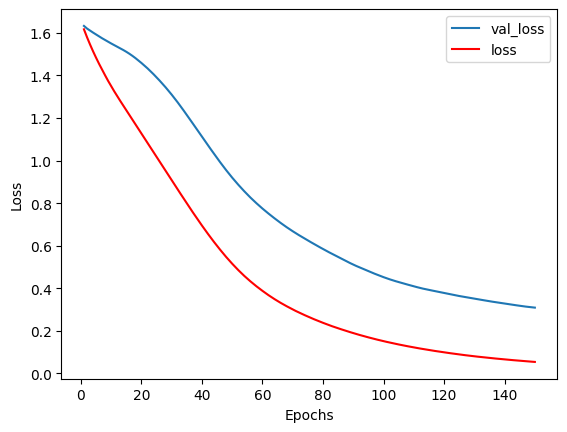

In [ ]:
# Visualisasi kurva loss
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, val_loss, '-', label='val_loss')
plt.plot(epochs, loss, 'r-', label='loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Tampilkan hasil restoran yang berada dalam jarak 20 km
print("Restoran yang berada dalam jarak 20 km dari pengguna:")
print(filtered_restaurants[['id_restaurant', 'id_reting', 'id_makanan', 'id_provinsi', 'nama_tempat', 'harga', 'alamat', 'deskripsi', 'long', 'lat', 'distance', 'cluster']].to_string(index=False))

Restoran yang berada dalam jarak 20 km dari pengguna:
 id_restaurant  id_reting  id_makanan  id_provinsi                                      nama_tempat                harga                                                                                                                                                                                               alamat                                                                                                                                 deskripsi       long       lat  distance  cluster
            17         17           7           31                               Kerak telor Betawi  Rp.15.000 - R30.000                                                                 Jalan.H.Mali No.30, RT.9/RW.8, Srengseng Sawah, Kec. Jagakarsa, Kota Jakarta Selatan, Daerah Khusus Ibukota Jakarta 12630, Indonesia                    Makanan ini terbuat dari nasi yang dicampur dengan telur dan serundeng, dimasak dengan cara dibakar di atas tungk

In [ ]:
# Menyimpan bobot model ke file HDF5
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Menyimpan arsitektur model ke file JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
SRC = '/content/model.h5'

In [ ]:
new_model = tf.keras.models.load_model(SRC)

# Check its architecture
new_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 128)               384       
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 dense_67 (Dense)            (None, 5)                 325       
                                                                 
Total params: 8965 (35.02 KB)
Trainable params: 8965 (35.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
